# DTSA 5510 Final Project, Otober 17, 2023
# Unsupervised Algorithms for Epileptic Seizure Recognition 

## Introduction
Seizures occur when groups of neurons in the brain abnormally increase their activity and behave erratically. This can result in convulsive movement, strange behaviors and/or sensations. Individuals experiencing chronic seizures are considered to have epilepsy and require medical treatment. These treatments include surgery, medication and lifestyle changes (Epilepsy and Seizures, 2023). Producing accurate models to detect epilepsy could help these individuals.

Electroencephalogram (EEG) is one of the procedures used to diagnose epilepsy. Neurons function by producing electrical signals. The EEG device rests on top of the head and uses small electrodes to detect the electrical signals emitted by groups of neurons (Rayi, 2022). The data produced is voltage changes over time. It should be noted that EEG results alone are not enough to diagnose epilepsy, and that an EEG can only detect neuronal activity at the surface layers of the brain, not in deeper structures (Epilepsy and Seizures, 2023).


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Import and Inspect Data

In [2]:
seizure = pd.read_csv('data/EpilepticSeizureRecognition.csv')
print(seizure.head())
print(seizure.info())

      Unnamed   X1   X2   X3   X4   X5   X6   X7   X8   X9  ...  X170  X171  \
0  X21.V1.791  135  190  229  223  192  125   55   -9  -33  ...   -17   -15   
1  X15.V1.924  386  382  356  331  320  315  307  272  244  ...   164   150   
2     X8.V1.1  -32  -39  -47  -37  -32  -36  -57  -73  -85  ...    57    64   
3   X16.V1.60 -105 -101  -96  -92  -89  -95 -102 -100  -87  ...   -82   -81   
4   X20.V1.54   -9  -65  -98 -102  -78  -48  -16    0  -21  ...     4     2   

   X172  X173  X174  X175  X176  X177  X178  y  
0   -31   -77  -103  -127  -116   -83   -51  4  
1   146   152   157   156   154   143   129  1  
2    48    19   -12   -30   -35   -35   -36  5  
3   -80   -77   -85   -77   -72   -69   -65  5  
4   -12   -32   -41   -65   -83   -89   -73  5  

[5 rows x 180 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 180 entries, Unnamed to y
dtypes: int64(179), object(1)
memory usage: 15.8+ MB
None


### Data Discription

The response variable is y in column 179, the Explanatory variables X1, X2, …, X178

y contains the category of the 178-dimensional input vector. Specifically y in {1, 2, 3, 4, 5}:

5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open

4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed

3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area

2 - They recorder the EEG from the area where the tumor was located

1 - Recording of seizure activity

All subjects falling in classes 2, 3, 4, and 5 are subjects who did not have epileptic seizure. Only subjects in class 1 have epileptic seizure.

(Andrzejak et al. 2018)

## Clean Data and Preprocessing

#### It looks like there are not any null values to deal with.

In [52]:
seizure.isnull().sum()

Unnamed    0
X1         0
X2         0
X3         0
X4         0
          ..
X175       0
X176       0
X177       0
X178       0
y          0
Length: 180, dtype: int64

#### Drop the column Unnamed because it is an induvial identifier and has no statistical value.

In [3]:
seizure = seizure.drop(columns=['Unnamed'])
print(seizure.head)

<bound method NDFrame.head of         X1   X2   X3   X4   X5   X6   X7   X8   X9  X10  ...  X170  X171  \
0      135  190  229  223  192  125   55   -9  -33  -38  ...   -17   -15   
1      386  382  356  331  320  315  307  272  244  232  ...   164   150   
2      -32  -39  -47  -37  -32  -36  -57  -73  -85  -94  ...    57    64   
3     -105 -101  -96  -92  -89  -95 -102 -100  -87  -79  ...   -82   -81   
4       -9  -65  -98 -102  -78  -48  -16    0  -21  -59  ...     4     2   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
11495  -22  -22  -23  -26  -36  -42  -45  -42  -45  -49  ...    15    16   
11496  -47  -11   28   77  141  211  246  240  193  136  ...   -65   -33   
11497   14    6  -13  -16   10   26   27   -9    4   14  ...   -65   -48   
11498  -40  -25   -9  -12   -2   12    7   19   22   29  ...   121   135   
11499   29   41   57   72   74   62   54   43   31   23  ...   -59   -25   

       X172  X173  X174  X175  X176  X177  X178  y  
0   

#### Normalize the data by absolute value and smoothe the absolute normalized data.
I would like to test different normalization techniques on model performance. I will absolute normalize the data and smooth the absolute data resulting in three datasets to test. Some processing of EEG data is warranted. The baseline voltage the EEG measures may differ for reasons that are not biological. The fact that the resting voltage in one recording is -35 and +10 in another may not be relevant. Also, the overall magnitude of the voltage changes may not be of great importance in EEG seizure detection, changes in frequency of events may be more relevant, (Rayi, 2022).

In [4]:
data_to_normalize = seizure.iloc[:, 1:-1]

# Absolute value scaling
X_abs = np.abs(data_to_normalize)
X_abs = pd.DataFrame(X_abs, columns=data_to_normalize.columns)
X_abs['y'] = seizure['y']

# Smooth the data using a moving average with a specified window size of 5
window_size = 5

# Create a DataFrame to store the smoothed data
X_smooth = pd.DataFrame(columns=X_abs.columns)

# Iterate through the rows starting from the 5th row
for i in range(window_size, len(data_to_normalize)):
    smoothed_row = data_to_normalize.iloc[i - window_size:i].mean()
    X_smooth = X_smooth.append(smoothed_row, ignore_index=True)

X_smooth['y'] = seizure['y']

# Reset the index
X_smooth.reset_index(drop=True, inplace=True)

X_data = pd.DataFrame(data_to_normalize, columns=data_to_normalize.columns)
X_data['y'] = seizure['y']

## Data Exploration

### Representative traces from original data and normalized data.

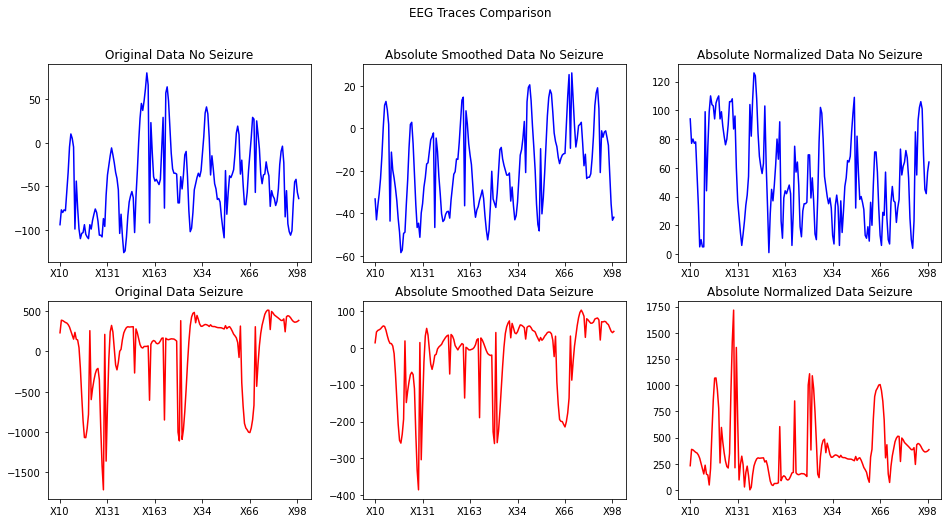

In [6]:
no_seizure = X_data[X_data['y'] == 5].iloc[0, :-1]
seizure = X_data[X_data['y'] == 1].iloc[0, :-1]

no_seizure_smooth = X_smooth[X_smooth['y'] == 5].iloc[0, :-1]
seizure_smooth = X_smooth[X_smooth['y'] == 1].iloc[0, :-1]

no_seizure_abs = X_abs[X_abs['y'] == 5].iloc[0, :-1]
seizure_abs = X_abs[X_abs['y'] == 1].iloc[0, :-1]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle('EEG Traces Comparison')

ax=sns.lineplot(data=no_seizure, color='blue', ax=axes[0, 0])
axes[0, 0].set_title('Original Data No Seizure')
ax.set_xticks(range(0, len(no_seizure), len(no_seizure) // 5))
ax=sns.lineplot(data=seizure, color='red', ax=axes[1, 0])
axes[1, 0].set_title('Original Data Seizure')
ax.set_xticks(range(0, len(seizure), len(seizure) // 5))

ax=sns.lineplot(data=no_seizure_smooth, color='blue', ax=axes[0, 1])
axes[0, 1].set_title('Absolute Smoothed Data No Seizure')
ax.set_xticks(range(0, len(no_seizure_smooth), len(no_seizure_smooth) // 5))
ax=sns.lineplot(data=seizure_smooth, color='red', ax=axes[1, 1])
axes[1, 1].set_title('Absolute Smoothed Data Seizure')
ax.set_xticks(range(0, len(seizure_smooth), len(seizure_smooth) // 5))

ax=sns.lineplot(data=no_seizure_abs, color='blue', ax=axes[0, 2])
axes[0, 2].set_title('Absolute Normalized Data No Seizure')
ax.set_xticks(range(0, len(no_seizure_abs), len(no_seizure_abs) // 5))
ax=sns.lineplot(data=seizure_abs, color='red', ax=axes[1, 2])
axes[1, 2].set_title('Absolute Normalized Data Seizure')
ax.set_xticks(range(0, len(seizure_abs), len(seizure_abs) // 5))

plt.show()

### The data is balance with each y variable having the same counts, 2300.

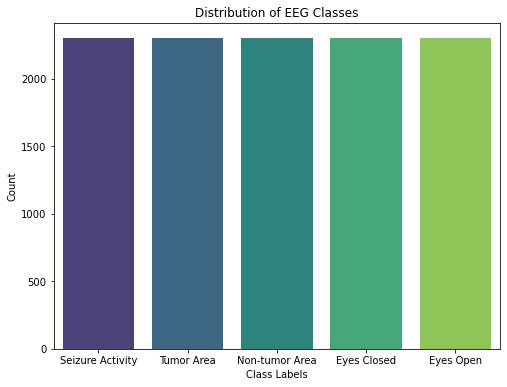

In [5]:
class_labels = {
    1: 'Seizure Activity',
    2: 'Tumor Area',
    3: 'Non-tumor Area',
    4: 'Eyes Closed',
    5: 'Eyes Open'
}

# Create a bar plot with custom x-axis labels
plt.figure(figsize=(8, 6))
sns.countplot(x='y', data=X_data, palette='viridis')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Distribution of EEG Classes')

# Set custom x-axis labels
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=[class_labels[i] for i in range(1, 6)])

plt.show()

### Scatter plots of Max and Min values for Eyes Open group vs Seixure Activity group.

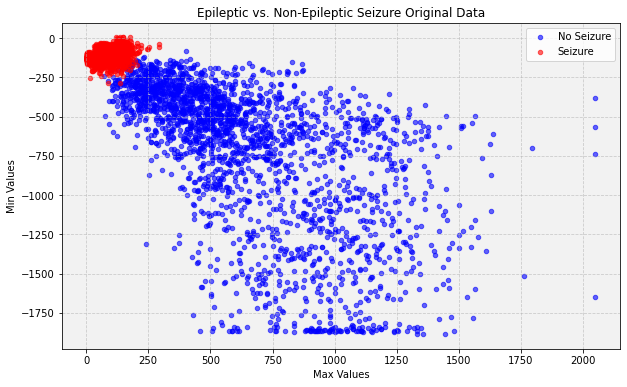

In [61]:
# Create a DataFrame for y=1 (seizure)
seizures = X_data[X_data['y'] == 1]

# Create a DataFrame for y=5 (no seizure)
non_seizures = X_data[X_data['y'] == 5]

# Compute max and min values 
x1_max, y1_min = np.max(seizures, axis=1), np.min(seizures, axis=1)
x2_max, y2_min = np.max(non_seizures, axis=1), np.min(non_seizures, axis=1)

# Create a scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(x1_max, y1_min, s=20, c='b', label='No Seizure', alpha=0.6)
ax.scatter(x2_max, y2_min, s=20, c='r', label='Seizure', alpha=0.6)

ax.set_xlabel('Max Values')
ax.set_ylabel('Min Values')
ax.set_title('Epileptic vs. Non-Epileptic Seizure Original Data')
ax.legend(loc='upper right')

ax.grid(True, linestyle='--', alpha=0.6)
ax.set_facecolor('#f2f2f2')

plt.show()

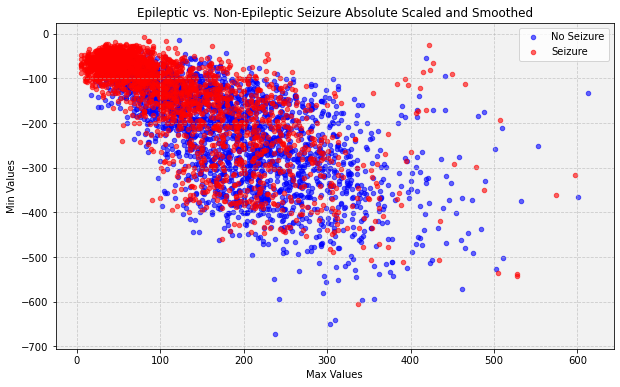

In [114]:
# Create a DataFrame for y=1 (seizure)
seizures_abs = X_smooth[X_smooth['y'] == 1]

# Create a DataFrame for y=5 (no seizure)
non_seizures_abs = X_smooth[X_smooth['y'] == 5]

# Compute max and min values 
x1_max, y1_min = np.max(seizures_abs, axis=1), np.min(seizures_abs, axis=1)
x2_max, y2_min = np.max(non_seizures_abs, axis=1), np.min(non_seizures_abs, axis=1)

# Create a scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(x1_max, y1_min, s=20, c='b', label='No Seizure', alpha=0.6)
ax.scatter(x2_max, y2_min, s=20, c='r', label='Seizure', alpha=0.6)

ax.set_xlabel('Max Values')
ax.set_ylabel('Min Values')
ax.set_title('Epileptic vs. Non-Epileptic Seizure Absolute Scaled and Smoothed')
ax.legend(loc='upper right')

ax.grid(True, linestyle='--', alpha=0.6)
ax.set_facecolor('#f2f2f2')

plt.show()

### Check for Associations in Response Variable
Although I did not suspect there would be any correlation between the y variables, I checked with Cramer’s V statistic. This looks for associations between categorical variables, with 0 indicating no association and 1 indicating a strong association. From the heat map it is clear there are no associations. 

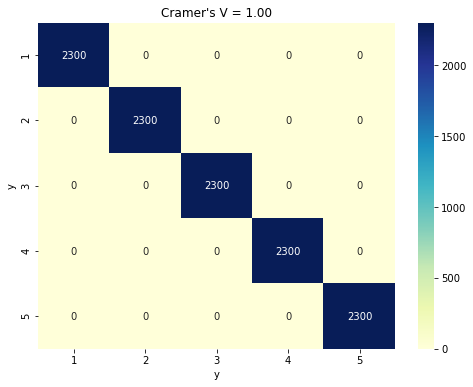

In [94]:
from scipy.stats import chi2_contingency

# 'y' is the categorical variable
y = seizure['y']

# Create a contingency table to calculate Cramer's V
contingency_table = pd.crosstab(y, y)

# Calculate Cramer's V
chi2, p, _, _ = chi2_contingency(contingency_table)
n = contingency_table.sum().sum()
cramer_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

# Create a heatmap to visualize the correlations
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title(f'Cramer\'s V = {cramer_v:.2f}')
plt.show()


## Models

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score, classification_report, confusion_matrix

### K-Nearest Neighbors (KNN)
#### I thought K-means would be a good model to start with because based on the scatter plots the data seems irregularly shaped.
#### Develop a function to easily run KNN on the three datasets with differnet number of neighbors.

In [7]:
def test_knn_accuracy(X, y):
    """
    Test K-Nearest Neighbors (K-NN) classifier accuracy with different numbers of neighbors.
    
    Parameters:
    - X: Features (input data).
    - y: Target variable (labels).
    - num_neighbors_list: List of numbers of neighbors to test.

    Returns:
    - List of accuracy scores for each number of neighbors in num_neighbors_list.
    """
    num_neighbors_list = (2, 3, 4, 5, 10)
    accuracy_scores = []

    for num_neighbors in num_neighbors_list:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        knn = KNeighborsClassifier(n_neighbors=num_neighbors)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

    return accuracy_scores

#### KNN Original Data

In [8]:
X_od = X_data.drop(columns=['y'])
y_od = X_data.iloc[:, -1:]

original_accuracies = test_knn_accuracy(X_od, y_od)
print('the accuracy scores for KNN of the original data for 2, 3, 4, 5 and 10 neighbors are:')
print(original_accuracies)

the accuracy scores for KNN of the original data for 2, 3, 4, 5 and 10 neighbors are:
[0.51, 0.4895652173913044, 0.4808695652173913, 0.4756521739130435, 0.4365217391304348]


#### KNN Smoothed Data

In [9]:
X_sm = X_smooth.drop(columns=['y'])
y_sm = X_smooth.iloc[:, -1:]

smoothed_accuracies = test_knn_accuracy(X_sm, y_sm)
print('the accuracy scores for KNN of the smoothed data for 2, 3, 4, 5 and 10 neighbors are:')
print(smoothed_accuracies)

the accuracy scores for KNN of the smoothed data for 2, 3, 4, 5 and 10 neighbors are:
[0.2035667681600696, 0.21009134406263594, 0.215311004784689, 0.2161809482383645, 0.23140495867768596]


#### KNN Absolute Normalized Data

In [10]:
X_abs = X_abs.drop(columns=['y'])
y_abs = X_data.iloc[:, -1:]

absolute_accuracies = test_knn_accuracy(X_abs, y_abs)
print('the accuracy scores for KNN of the absolute normalized data for 2, 3, 4, 5 and 10 neighbors are:')
print(absolute_accuracies)

the accuracy scores for KNN of the absolute normalized data for 2, 3, 4, 5 and 10 neighbors are:
[0.4443478260869565, 0.4369565217391304, 0.4308695652173913, 0.4273913043478261, 0.41347826086956524]


### K-Means Clustering
#### The kmeans_elbow function will measure the km.inertia to help identify the best number of clusters find in each dataset.

In [11]:
def kmeans_elbow(X, max_clusters=10):
    kmeans_list = []

    for clusters in range(1, max_clusters + 1):
        km = KMeans(n_clusters=clusters, random_state=42)
        km = km.fit(X)
        kmeans_list.append(pd.Series({'clusters': clusters, 
                                      'inertia': km.inertia_,
                                      'model': km}))

    # Prepare data for plotting
    elbow_graph_data = pd.concat(kmeans_list, axis=1).T
    elbow_graph_data['clusters'] = elbow_graph_data['clusters'].astype(int)

    # Plot the elbow graph
    plt.figure(figsize=(8, 6))
    plt.plot(elbow_graph_data['clusters'], elbow_graph_data['inertia'], marker='o')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()
    
    return elbow_graph_data


elbow graph for optimum number of clusters for kmeans with original data:


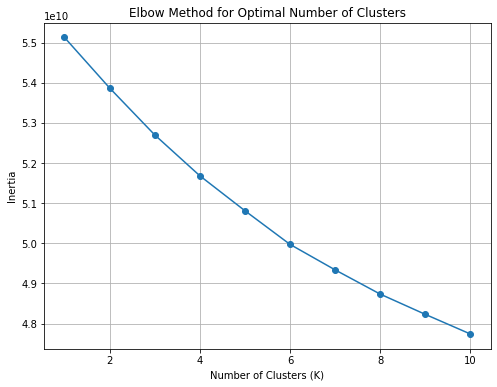

In [12]:
print('elbow graph for optimum number of clusters for kmeans with original data:')
original_data_elbow = kmeans_elbow(X_od)


elbow graph for optimum number of clusters for kmeans with smoothed data:


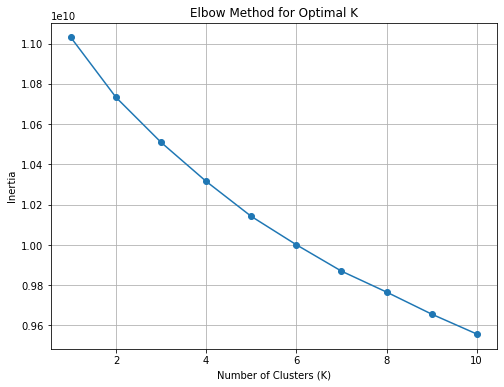

In [123]:
print('elbow graph for optimum number of clusters for kmeans with smoothed data:')
smoothed_data_elbow = kmeans_elbow(X_sm)

elbow graph for optimum number of clusters for kmeans with absolute scaled data:


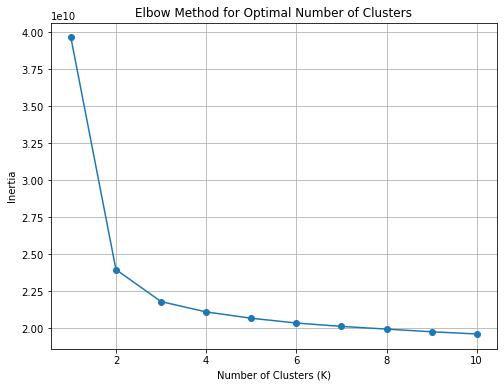

In [74]:
print('elbow graph for optimum number of clusters for kmeans with absolute scaled data:')
absolute_data_elbow = kmeans_elbow(X_abs)

### The kmeans_clustering function will perfom kmeans clustering and return model evaluation metrics.
#### Since the elbow graphs for the original and soothed data sets did not show any significant trends I will set the number of clusters to 5, because there are five groups in the dataset.

In [13]:
def kmeans_clustering(X, y, num_clusters):
    # Fit K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)

    # Calculate clustering evaluation metrics
    ari = adjusted_rand_score(y, cluster_labels)
    nmi = normalized_mutual_info_score(y, cluster_labels)
    cm = confusion_matrix(y, cluster_labels)

    return ari, nmi, cm


#### K-Means with Original Data and 5 Clusters.

In [14]:
X = X_od  
y = y_od['y']
num_clusters = 5

ari_od, nmi_od, cm_od = kmeans_clustering(X, y, num_clusters)
print('K-Means clustering for original data')
print(f'Adjusted Rand Index (ARI): {ari_od:.2f}')
print(f'Normalized Mutual Information (NMI): {nmi_od:.2f}')
print('Confusion Matrix:')
print(cm_od)

K-Means clustering for original data
Adjusted Rand Index (ARI): 0.02
Normalized Mutual Information (NMI): 0.11
Confusion Matrix:
[[   0    0    0    0    0    0]
 [ 327  625  352  223  773    0]
 [   3  793    7    2 1495    0]
 [   0  808    0    0 1492    0]
 [   0  847    0    0 1453    0]
 [   0  645    0    0 1655    0]]


#### K-Means with Smoothed Normalized Data and 5 Clusters.

In [15]:
X = X_sm  
y = y_sm['y']
num_clusters = 5

ari_sm, nmi_sm, cm_sm = kmeans_clustering(X, y, num_clusters)
print('K-Means clustering for smoothed data')
print(f'Adjusted Rand Index (ARI): {ari_sm:.2f}')
print(f'Normalized Mutual Information (NMI): {nmi_sm:.2f}')
print('Confusion Matrix:')
print(cm_sm)

K-Means clustering for smoothed data
Adjusted Rand Index (ARI): 0.01
Normalized Mutual Information (NMI): 0.01
Confusion Matrix:
[[   0    0    0    0    0    0]
 [ 323  638  348  683  307    0]
 [ 168  872  162  939  158    0]
 [ 146  862  160  935  196    0]
 [ 151  929  164  911  144    0]
 [ 158  814  160 1003  164    0]]


 #### K-Means with Absolute Normalized Data and 5 Clusters.

In [16]:
X = X_abs  
y = y_abs['y']
num_clusters = 5

ari_ab, nmi_ab, cm_ab = kmeans_clustering(X, y, num_clusters)
print('K-Means clustering for absolute value sclaed data')
print(f'Adjusted Rand Index (ARI): {ari_ab:.2f}')
print(f'Normalized Mutual Information (NMI): {nmi_ab:.2f}')
print('Confusion Matrix:')
print(cm_ab)

K-Means clustering for absolute value sclaed data
Adjusted Rand Index (ARI): 0.12
Normalized Mutual Information (NMI): 0.29
Confusion Matrix:
[[   0    0    0    0    0    0]
 [   4  514  459  741  582    0]
 [1704   26    1   78  491    0]
 [1840    0    0    0  460    0]
 [1459    0    0    0  841    0]
 [2126    0    0    0  174    0]]


#### K-Means with Absolute Normalized Data and 4 Clusters.
From the elbow graph it looked like the optimal number of cluster for the absolute data was 4.

In [17]:
X = X_abs 
y = y_od['y']
num_clusters = 4

ari_ab_4, nmi_ab_4, cm_ab_4 = kmeans_clustering(X, y, num_clusters)
print('K-Means clustering for absolute value sclaed data')
print(f'Adjusted Rand Index (ARI): {ari_ab_4:.2f}')
print(f'Normalized Mutual Information (NMI): {nmi_ab_4:.2f}')
print('Confusion Matrix:')
print(cm_ab_4)

K-Means clustering for absolute value sclaed data
Adjusted Rand Index (ARI): 0.13
Normalized Mutual Information (NMI): 0.30
Confusion Matrix:
[[   0    0    0    0    0    0]
 [  14  965  615  706    0    0]
 [1839   62    6  393    0    0]
 [1980    0    0  320    0    0]
 [1651    0    0  649    0    0]
 [2196    0    0  104    0    0]]


### Use Principal Component Anaylsis (PCA) to Reduce Dimensions
#### I will first optimize the number of componets for PCA by measuring the explained variance wiht different numbers of components.

In [18]:
def optimize_pca_components(X):
    """
    Perform PCA and optimize the number of components using explained variance.

    Parameters:
    X (array-like): Feature matrix.

    Returns:
    optimal_n_components (int): The optimal number of PCA components.
    """

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform PCA with different numbers of components
    n_components = range(5, 61, 5)
    explained_variance = []

    for n in n_components:
        pca = PCA(n_components=n)
        pca.fit(X_scaled)
        explained_variance.append(sum(pca.explained_variance_ratio_))

    # Plot the explained variance
    plt.plot(n_components, explained_variance, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid()
    plt.show()

    # Find the elbow point (where explained variance levels off)
    optimal_n_components = explained_variance.index(max(explained_variance)) + 1

    return optimal_n_components


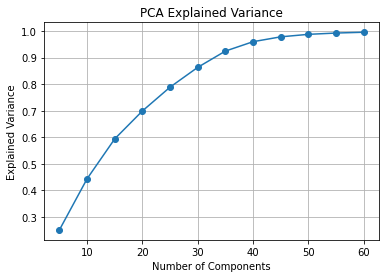

Optimal Number of Components for the Original Dataset: 12


In [17]:
optimal_n_components_od = optimize_pca_components(X_od)
print(f'Optimal Number of Components for the Original Dataset: {optimal_n_components_od}')

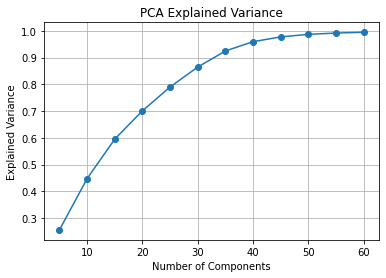

Optimal Number of Components for the Smoothed Dataset: 12


In [21]:
optimal_n_components_sm = optimize_pca_components(X_sm)
print(f'Optimal Number of Components for the Smoothed Dataset: {optimal_n_components_sm}')

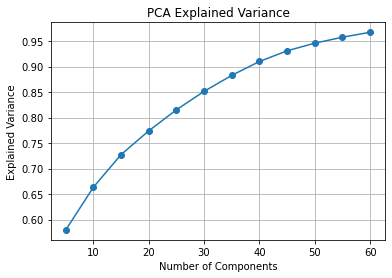

Optimal Number of Components for the Absolute Normalized Dataset: 12


In [110]:
optimal_n_components_ab = optimize_pca_components(X_abs)
print(f'Optimal Number of Components for the Absolute Normalized Dataset: {optimal_n_components_ab}')

#### It looks like 12 is the optimal number of components for each dataset. I will now preform pca on each of the datasets and check their performance with the previous clustering models. 


In [20]:
# Run PCA with 12 components on X_od
pca_od = PCA(n_components=12)
X_od_pca = pca_od.fit_transform(X_od)

# Run PCA with 12 components on X_sm
pca_sm = PCA(n_components=12)
X_sm_pca = pca_sm.fit_transform(X_sm)

# Run PCA with 12 components on X_sm
pca_ab = PCA(n_components=12)
X_ab_pca = pca_ab.fit_transform(X_abs)

explained_variance_od = sum(pca_od.explained_variance_ratio_)
explained_variance_sm = sum(pca_sm.explained_variance_ratio_)
explained_variance_ab = sum(pca_ab.explained_variance_ratio_)
print(explained_variance_od)
print(explained_variance_sm)
print(explained_variance_ab)

0.5102053069331135
0.511300645545565
0.691118386077612


#### KNN and K-Means with Original Data After PCA

In [21]:
X = X_od_pca 
y = y_od['y']
num_clusters = 5

ari_od_pca, nmi_od_pca, cm_od_pca = kmeans_clustering(X, y, num_clusters)
print('K-Means clustering for original data')
print(f'Adjusted Rand Index (ARI): {ari_od_pca:.2f}')
print(f'Normalized Mutual Information (NMI): {nmi_od_pca:.2f}')
print('Confusion Matrix:')
print(cm_od_pca)

K-Means clustering for original data
Adjusted Rand Index (ARI): 0.03
Normalized Mutual Information (NMI): 0.12
Confusion Matrix:
[[   0    0    0    0    0    0]
 [ 349  734  320  334  563    0]
 [   6 1486    3   11  794    0]
 [   0 1496    0    0  804    0]
 [   0 1451    0    0  849    0]
 [   0 1655    0    0  645    0]]


In [22]:
original_pca_accuracies = test_knn_accuracy(X_od_pca, y_od)
print('the accuracy scores for KNN of the original data for 2, 3, 4, 5 and 10 neighbors are:')
print(original_pca_accuracies)

the accuracy scores for KNN of the original data for 2, 3, 4, 5 and 10 neighbors are:
[0.47391304347826085, 0.46391304347826084, 0.4691304347826087, 0.47304347826086957, 0.46869565217391307]


#### KNN and K-Menas with Smoothed Data After PCA

In [23]:
X = X_sm_pca 
y = y_sm['y']
num_clusters = 5

ari_sm_pca, nmi_sm_pca, cm_sm_pca = kmeans_clustering(X, y, num_clusters)
print('K-Means clustering for original data')
print(f'Adjusted Rand Index (ARI): {ari_sm_pca:.2f}')
print(f'Normalized Mutual Information (NMI): {nmi_sm_pca:.2f}')
print('Confusion Matrix:')
print(cm_sm_pca)

K-Means clustering for original data
Adjusted Rand Index (ARI): 0.01
Normalized Mutual Information (NMI): 0.01
Confusion Matrix:
[[  0   0   0   0   0   0]
 [679 314 334 663 309   0]
 [903 162 158 912 164   0]
 [894 145 165 914 181   0]
 [880 146 158 965 150   0]
 [955 169 160 854 161   0]]


In [24]:
smoothed_pca_accuracies = test_knn_accuracy(X_sm_pca, y_sm)
print('the accuracy scores for KNN of the original data for 2, 3, 4, 5 and 10 neighbors are:')
print(smoothed_pca_accuracies)

the accuracy scores for KNN of the original data for 2, 3, 4, 5 and 10 neighbors are:
[0.21574597651152674, 0.20574162679425836, 0.2083514571552849, 0.22140060896041758, 0.2301000434971727]


#### KNN and K-Menas with Absolute Normalized Data After PCA

In [25]:
X = X_ab_pca 
y = y_od['y']
num_clusters = 4

ari_ab_pca, nmi_ab_pca, cm_ab_pca = kmeans_clustering(X, y, num_clusters)
print('K-Means clustering for absolute value sclaed data')
print(f'Adjusted Rand Index (ARI): {ari_ab_pca:.2f}')
print(f'Normalized Mutual Information (NMI): {nmi_ab_pca:.2f}')
print('Confusion Matrix:')
print(cm_ab_pca)

K-Means clustering for absolute value sclaed data
Adjusted Rand Index (ARI): 0.13
Normalized Mutual Information (NMI): 0.30
Confusion Matrix:
[[   0    0    0    0    0    0]
 [  14  961  703  622    0    0]
 [1840   62  392    6    0    0]
 [1984    0  316    0    0    0]
 [1651    0  649    0    0    0]
 [2196    0  104    0    0    0]]


In [26]:
absolute_pca_accuracies = test_knn_accuracy(X_ab_pca, y_od)
print('the accuracy scores for KNN of the original data for 2, 3, 4, 5 and 10 neighbors are:')
print(absolute_pca_accuracies)

the accuracy scores for KNN of the original data for 2, 3, 4, 5 and 10 neighbors are:
[0.5043478260869565, 0.49826086956521737, 0.5134782608695653, 0.5239130434782608, 0.5143478260869565]


## Summary table of KNN results of all three datasets after PCA. 

In [44]:
# round accuracy values 
rounded_original_pca_knn = [round(value, 2) for value in original_pca_accuracies]
rounded_smooth_pca_knn = [round(value, 2) for value in smoothed_pca_accuracies]
rounded_absolute_pca_knn = [round(value, 2) for value in absolute_pca_accuracies]

data = {
    'Dataset': ['Original Data', 'Smoothed Data', 'Absolute Data'],
    'KNN Accuracy 2, 3, 4, 5, 10': [rounded_original_pca_knn, rounded_smooth_pca_knn, rounded_absolute_pca_knn]
}

table1 = pd.DataFrame(data)

print("Accuracy Results From KNN Of All Three Dataset After PCA ")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)  # Ensures long lists aren't truncated

print(table1)

Accuracy Results From KNN Of All Three Dataset After PCA 
         Dataset     KNN Accuracy 2, 3, 4, 5, 10
0  Original Data  [0.47, 0.46, 0.47, 0.47, 0.47]
1  Smoothed Data  [0.22, 0.21, 0.21, 0.22, 0.23]
2  Absolute Data    [0.5, 0.5, 0.51, 0.52, 0.51]


## Summary table of KNN results with absolute normalized data before and after PCA. 

In [45]:
# round accuracy values 
rounded_absolute_accuracies = [round(value, 2) for value in absolute_accuracies]
rounded_pca_accuracies = [round(value, 2) for value in absolute_pca_accuracies]

data = {
    'Dataset': ['Absolute Data', 'PCA Absolute Data'],
    'KNN Accuracy 2, 3, 4, 5, 10': [rounded_absolute_accuracies, rounded_pca_accuracies]
}

table2 = pd.DataFrame(data)

print("Accuracy Results For KNN With Absolute Normalized Data")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)  # Ensures long lists aren't truncated

print(table2)


Accuracy Results For KNN With Absolute Normalized Data
             Dataset     KNN Accuracy 2, 3, 4, 5, 10
0      Absolute Data  [0.44, 0.44, 0.43, 0.43, 0.41]
1  PCA Absolute Data    [0.5, 0.5, 0.51, 0.52, 0.51]


## Conclusion:

The appropriate clustering method to analyze EEG data depends on multiple factors. One of these is the way the data is preprocessed. Here I show that data normalization can greatly impact the performance of k-means and KNN clustering approaches. Also, dimensionality reduction through PCA can alter model performance. With this dataset I saw a slight improvement in the absolute normalized data after PCA. 

I think there are several improvements that could be made to these models. First, there was no age or gender information given for the participants in this study. Ko, J, et al. (2021), point out that EEG measurements can differ by age and gender. Controlling for these factors and ensuring the data is balanced may impact model performance. Also, dividing the data into appropriate groups and defining the control groups is important. Here, one of the non-seizure groups had a positive brain cancer diagnosis. Brain tumors can result in altered EEG recordings (Preuß et al., 2015). This type of important domain knowledge will impact how the appropriate number of clusters is determined. Finally, looking into other normalization techniques could improve model performance. Rayi, A. (2022), describes other more involved preprocessing of EEG data for seizure detection. 

## Referecnces:

#### Data
Andrzejak RG, Lehnertz K, Rieke C, Mormann F, David P, Elger CE. Epileptic seizure Recognition. (2018, October 11). Kaggle. https://www.kaggle.com/datasets/harunshimanto/epileptic-seizure-recognition/data

#### Backgroud Information
Da Silva, F. L. (2018). EEG analysis: Theory and Practice. In HAL (Le Centre pour la Communication Scientifique Directe). French National Centre for Scientific Research. https://hal.archives-ouvertes.fr/hal-01953609

Epilepsy and Seizures. (2023, August 15). National Institute of Neurological Disorders and Stroke. Retrieved October 11, 2023, from https://www.ninds.nih.gov/health-information/disorders/epilepsy-and-seizures![image.png](attachment:image.png)

Ko, J., Park, U., Kim, D., & Kang, S. W. (2021). Quantitative Electroencephalogram Standardization: A Sex- and Age-Differentiated Normative Database. Frontiers in Neuroscience, 15. https://doi.org/10.3389/fnins.2021.766781![image.png](attachment:image.png)

Preuß, M., Preiss, S., Syrbe, S., Nestler, U., Fischer, L., Merkenschlager, A., Bertsche, A., Christiansen, H., & Bernhard, M. K. (2015). Signs and symptoms of pediatric brain tumors and diagnostic value of preoperative EEG. Childs Nervous System, 31(11), 2051–2054. https://doi.org/10.1007/s00381-015-2842-z![image.png](attachment:image.png)

Rayi, A. (2022, October 3). Electroencephalogram. StatPearls - NCBI Bookshelf. https://www.ncbi.nlm.nih.gov/books/NBK563295/![image.png](attachment:image.png)